In [1]:
!nvcc -V
!gcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Sun Jan  8 08:11:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+====

In [2]:
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

!pip install mmcv-full

!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

!pip install Pillow==7.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.4/704.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.5.1+cu101 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==

In [6]:
import cv2
import os
import shutil
import copy
import os.path as osp

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmdet
print(mmdet.__version__)

from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import mmcv
import numpy as np
import pandas as pd

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import set_random_seed

1.5.1+cu101 True
2.27.0
11.2
GCC 7.5


In [7]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d antoreepjana/animals-detection-images-dataset

Saving kaggle.json to kaggle.json
100% 8.92G/8.92G [04:42<00:00, 38.7MB/s]
100% 8.92G/8.92G [04:42<00:00, 33.9MB/s]


In [ ]:
!unzip animals-detection-images-dataset.zip -d /content/animals


In [9]:
import os
import glob
data_dir="/content/animals"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")
train_classes=[os.path.basename(pp) for pp in all_train_subdir]
test_classes=[os.path.basename(pp) for pp in all_test_subdir]

print("В обучающей выборке %d классов, в тестовой выборке %d классов"%(len(train_classes), len(test_classes)))


В обучающей выборке 80 классов, в тестовой выборке 80 классов


### Животные для детекции

In [10]:
classes = ['Eagle', 'Bull', 'Tiger',  'Pig', 'Crab', 'Goat', 
         'Snake', 'Sheep', 'Goose', 'Squirrel', 'Frog', 
         'Mouse', 'Chicken', 'Horse', 'Bear']

In [11]:
train_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_train_subdir}
test_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_test_subdir}
train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df = all_data_df.sort_values(by=['train'], ascending=False)
all_data_df = all_data_df.loc[classes]
all_data_df.T

,Eagle,Bull,Tiger,Pig,Crab,Goat,Snake,Sheep,Goose,Squirrel,Frog,Mouse,Chicken,Horse,Bear
train,719,47,313,190,309,202,562,99,289,367,588,151,388,400,87
test,178,73,26,96,114,94,213,74,33,68,77,83,137,143,39


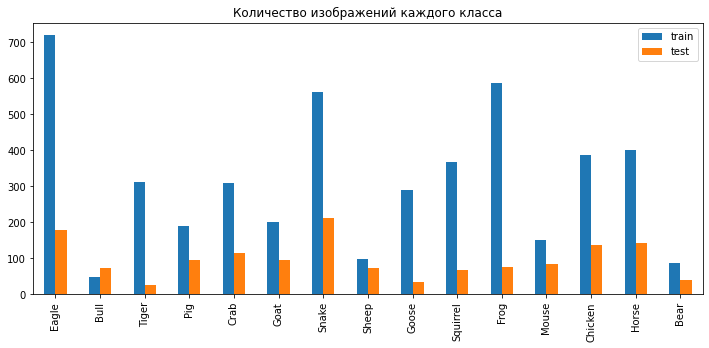

In [20]:
all_data_df.plot(kind="bar", legend=True, figsize=(12,5), title="Количество изображений каждого класса");

In [21]:
os.mkdir("r_cnn")
os.mkdir("r_cnn/test")
os.mkdir("r_cnn/test/images")
os.mkdir("r_cnn/test/labels")
os.mkdir("r_cnn/train")
os.mkdir("r_cnn/train/images")
os.mkdir("r_cnn/train/labels")


In [22]:
!cd ./
!ls


animals-detection-images-dataset.zip  MANIFEST.in      requirements
CITATION.cff			      mmdet	       requirements.txt
configs				      mmdet.egg-info   resources
demo				      model-index.yml  setup.cfg
docker				      pytest.ini       setup.py
docs				      r_cnn	       tests
kaggle.json			      README.md        tools
LICENSE				      README_zh-CN.md


### Подготовка набора данных

In [23]:
#test
for animal_specie in classes:
    image_file_name = os.listdir(test_dir+"/"+animal_specie)
    for i in range(0,len(image_file_name)):
            if image_file_name[i] != "Label":
                img = cv2.imread(test_dir+"/"+animal_specie+"/"+image_file_name[i], cv2.IMREAD_COLOR)
                cv2.imwrite("/content/mmdetection/r_cnn/test/images/"+image_file_name[i], img)
                with open('r_cnn/an_test.txt', 'a') as k:
                    k.write(image_file_name[i][:-4] + '\n' )

    txt_file_name = os.listdir(test_dir+"/"+animal_specie+"/Label")
    for i in range(0,len(txt_file_name)):
                with open(test_dir+"/"+animal_specie + "/Label/" + txt_file_name[i], "r") as source:
                      d = source.read()
                      with open('/content/mmdetection/r_cnn/test/labels'+"/"+ txt_file_name[i], "w") as destination:
                            destination.write(d)
                            



#train
for animal_specie in classes:
    image_file_name = os.listdir(train_dir+"/"+animal_specie)
    for i in range(0,len(image_file_name)):
            if image_file_name[i] != "Label":
                img = cv2.imread(train_dir+"/"+animal_specie+"/"+image_file_name[i], cv2.IMREAD_COLOR)
                cv2.imwrite("/content/mmdetection/r_cnn/train/images/"+image_file_name[i], img)
                with open('r_cnn/an_train.txt', 'a') as e:
                    e.write(image_file_name[i][:-4] + '\n' )

    txt_file_name = os.listdir(train_dir+"/"+animal_specie+"/Label")
    for i in range(0,len(txt_file_name)):
                with open(train_dir+"/"+animal_specie + "/Label/" + txt_file_name[i], "r") as source:
                      d = source.read()
                      # print(d)
                      with open('/content/mmdetection/r_cnn/train/labels'+"/"+ txt_file_name[i], "w") as destination:
                            destination.write(d)
                            

###Создание датасета (middle format)

In [24]:


@DATASETS.register_module()
class AnimalsDetectionDataset(CustomDataset):

    CLASSES = tuple(classes)

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            label_prefix = self.img_prefix.replace('images', 'labels')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split() for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [25]:
model = 'cascade_rcnn'
if model == 'cascade_rcnn':
  cfg = Config.fromfile('/content/mmdetection/configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco.py')
elif model == 'ssd':
  cfg = Config.fromfile('/content/mmdetection/configs/ssd/ssd300_coco.py')


#### Веса для инициализации

In [26]:
!mkdir checkpoints

!wget -c http://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_caffe_fpn_1x_coco/cascade_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.404_20200504_174853-b857be87.pth -O /content/mmdetection/checkpoints/cascade_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.404_20200504_174853-b857be87.pth

!wget -c http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2092.pth \
      -O /content/mmdetection/checkpoints/ssd300_coco_20200307-a92d2092.pth      

--2023-01-08 08:57:53--  http://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_caffe_fpn_1x_coco/cascade_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.404_20200504_174853-b857be87.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.48.207, 47.246.48.210, 47.246.48.205, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.48.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277864232 (265M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/cascade_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.404_20200504_174853-b857be87.pth’

/content/mmdetectio 100%[===================>] 264.99M  38.4MB/s    in 7.3s    

2023-01-08 08:58:01 (36.2 MB/s) - ‘/content/mmdetection/checkpoints/cascade_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.404_20200504_174853-b857be87.pth’ saved [277864232/277864232]

--2023-01-08 08:58:01--  http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2

In [27]:
cfg["data"]

{'samples_per_gpu': 2,
 'workers_per_gpu': 2,
 'train': {'type': 'CocoDataset',
  'ann_file': 'data/coco/annotations/instances_train2017.json',
  'img_prefix': 'data/coco/train2017/',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'LoadAnnotations', 'with_bbox': True},
   {'type': 'Resize', 'img_scale': (1333, 800), 'keep_ratio': True},
   {'type': 'RandomFlip', 'flip_ratio': 0.5},
   {'type': 'Normalize',
    'mean': [123.675, 116.28, 103.53],
    'std': [58.395, 57.12, 57.375],
    'to_rgb': True},
   {'type': 'Pad', 'size_divisor': 32},
   {'type': 'DefaultFormatBundle'},
   {'type': 'Collect', 'keys': ['img', 'gt_bboxes', 'gt_labels']}]},
 'val': {'type': 'CocoDataset',
  'ann_file': 'data/coco/annotations/instances_val2017.json',
  'img_prefix': 'data/coco/val2017/',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'MultiScaleFlipAug',
    'img_scale': (1333, 800),
    'flip': False,
    'transforms': [{'type': 'Resize', 'keep_ratio': True},
     {'type': 'Rand

In [28]:

cfg.dataset_type = 'AnimalsDetectionDataset'
cfg.data_root = '/content/mmdetection/r_cnn/'

cfg.data.test.type = 'AnimalsDetectionDataset'
cfg.data.test.data_root = '/content/mmdetection/r_cnn/'
cfg.data.test.ann_file = '/content/mmdetection/r_cnn/an_test.txt'
cfg.data.test.img_prefix = 'test/images'


cfg.data.val.type = 'AnimalsDetectionDataset'
cfg.data.val.data_root = '/content/mmdetection/r_cnn/'
cfg.data.val.ann_file = '/content/mmdetection/r_cnn/an_test.txt'
cfg.data.val.img_prefix = 'test/images'

if model == 'cascade_rcnn':
  for i in cfg.model.roi_head.bbox_head:
    i.num_classes = 15
  cfg.load_from = '/content/mmdetection/checkpoints/cascade_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.404_20200504_174853-b857be87.pth'

  cfg.data.train.type = 'AnimalsDetectionDataset'
  cfg.data.train.data_root = '/content/mmdetection/r_cnn/'
  cfg.data.train.ann_file = '/content/mmdetection/r_cnn/an_train.txt'
  cfg.data.train.img_prefix = 'train/images'

elif model == 'ssd':
  cfg.model.bbox_head.num_classes = 15
  cfg.load_from = '/content/mmdetection/checkpoints/ssd300_coco_20200307-a92d2092.pth'
  
  cfg.data.train.dataset.type = 'AnimalsDetectionDataset'
  cfg.data.train.dataset.data_root = '/content/mmdetection/r_cnn/'
  cfg.data.train.dataset.ann_file = '/content/mmdetection/r_cnn/an_train.txt'
  cfg.data.train.dataset.img_prefix = 'train/images'
  

cfg.work_dir = '/content/exp'

cfg.optimizer.lr = 0.02 / 8. 
cfg.lr_config.warmup = None
cfg.lr_config.warmup_ratio = 1.0 / 1e10
cfg.log_config.interval = 100

cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 5
cfg.checkpoint_config.interval = 1
cfg.runner.max_epochs = 5

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='CascadeRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_

### Обучение

In [ ]:
datasets = [build_dataset(cfg.data.train)]

model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

<ipython-input-15-d7f148b76412>:40: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels=np.array(gt_labels, dtype=np.long),
<ipython-input-15-d7f148b76412>:42: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `n

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1448/1448, 6.5 task/s, elapsed: 222s, ETA:     0s
---------------iou_thr: 0.5---------------


2023-01-07 11:35:13,507 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| Eagle    | 190 | 338  | 0.974  | 0.944 |
| Bull     | 90  | 107  | 0.389  | 0.257 |
| Tiger    | 27  | 40   | 0.704  | 0.615 |
| Pig      | 127 | 986  | 0.874  | 0.606 |
| Crab     | 120 | 1108 | 0.917  | 0.719 |
| Goat     | 89  | 769  | 0.854  | 0.419 |
| Snake    | 219 | 678  | 0.913  | 0.699 |
| Sheep    | 116 | 873  | 0.767  | 0.157 |
| Goose    | 42  | 954  | 0.976  | 0.581 |
| Squirrel | 68  | 618  | 0.956  | 0.670 |
| Frog     | 79  | 536  | 0.911  | 0.699 |
| Mouse    | 88  | 467  | 0.898  | 0.567 |
| Chicken  | 166 | 1303 | 0.916  | 0.777 |
| Horse    | 166 | 688  | 0.861  | 0.582 |
| Bear     | 42  | 283  | 0.786  | 0.398 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.579 |
+----------+-----+------+--------+-------+
2023-01-07 11:35:13,714 - mmdet - INFO - Epoch(val) [5]

In [ ]:
import requests
import json
import time
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import requests

import os
import sys

import urllib


In [ ]:
token = ''
name_page = 'id505170562'
album_name = 'wall'
user_id = requests.get(f'https://api.vk.com/method/users.get?v=5.131&access_token={token}&user_ids={name_page}')
temp = user_id.json()
idx = temp["response"][0]['id']
request = requests.get(f'https://api.vk.com/method/photos.get?v=5.131&access_token={token}&owner_id={idx}&album_id={album_name}')
urls = []

for i in request.json()['response']['items']:
    for j in i['sizes']:
        if j['type'] == 'r':
            url = j['url']
            urls.append(url)

def download(url, pathname='vk1111'):
    if not os.path.isdir(pathname):
        os.makedirs(pathname)
    response = requests.get(url, stream=True)
    filename = os.path.join(pathname, url.split('/')[-1].split('?')[0])
    with open(filename, "wb") as file:
        for i in response.iter_content(4096):
            file.write(i)

for i in urls:
    download(i, '/content/vk_image')

### Результат

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

model.cfg = cfg
images = []
directory = '/content/vk_image'

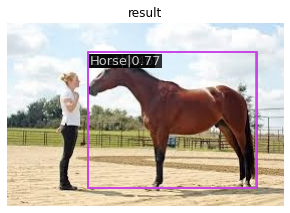

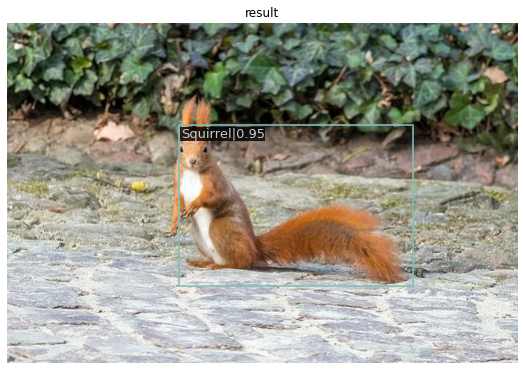

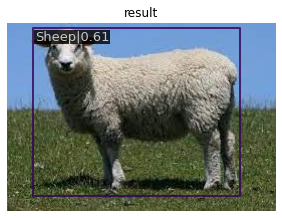

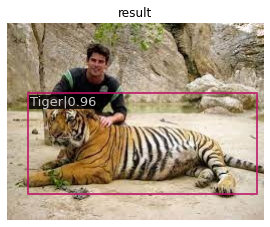

In [ ]:
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      images.append(f)

for image in images:
    img = mmcv.imread(image)
    result = inference_detector(model, img)
    show_result_pyplot(model, img, result)